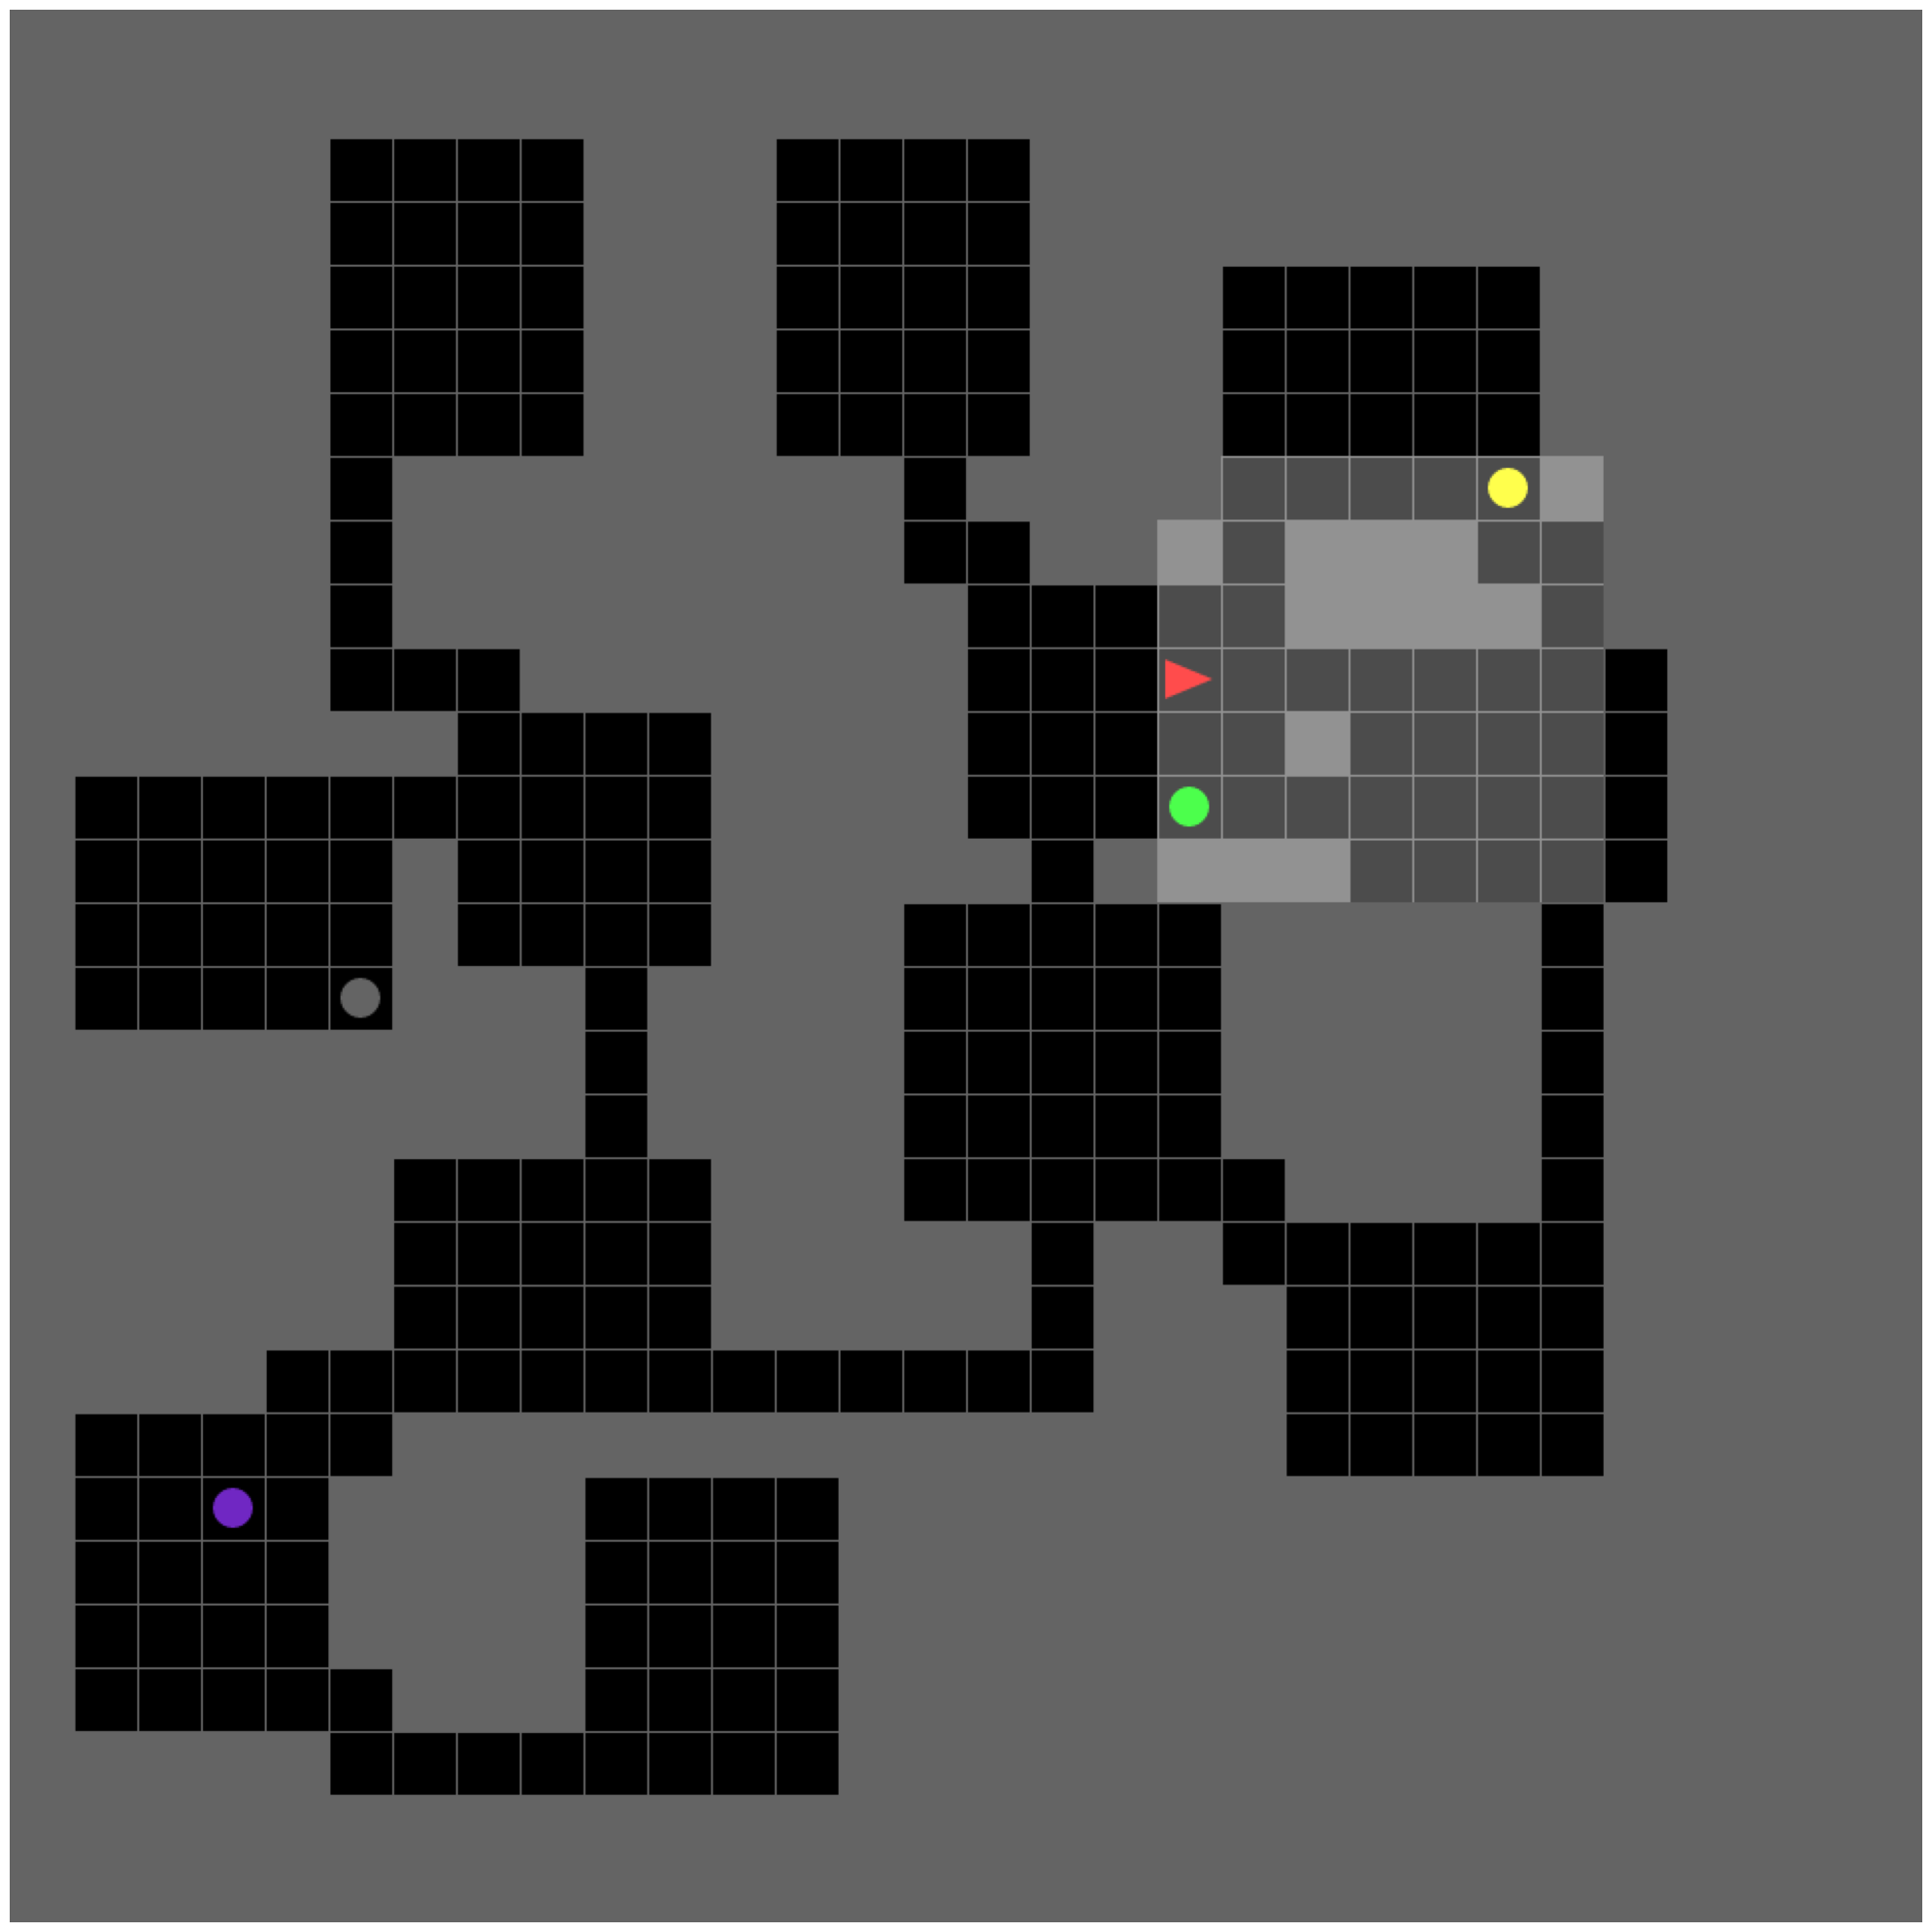

Navigate to the colored balls.
grey
Agent position: (np.int64(18), np.int64(10)), goal position: (np.int64(5), np.int64(15))


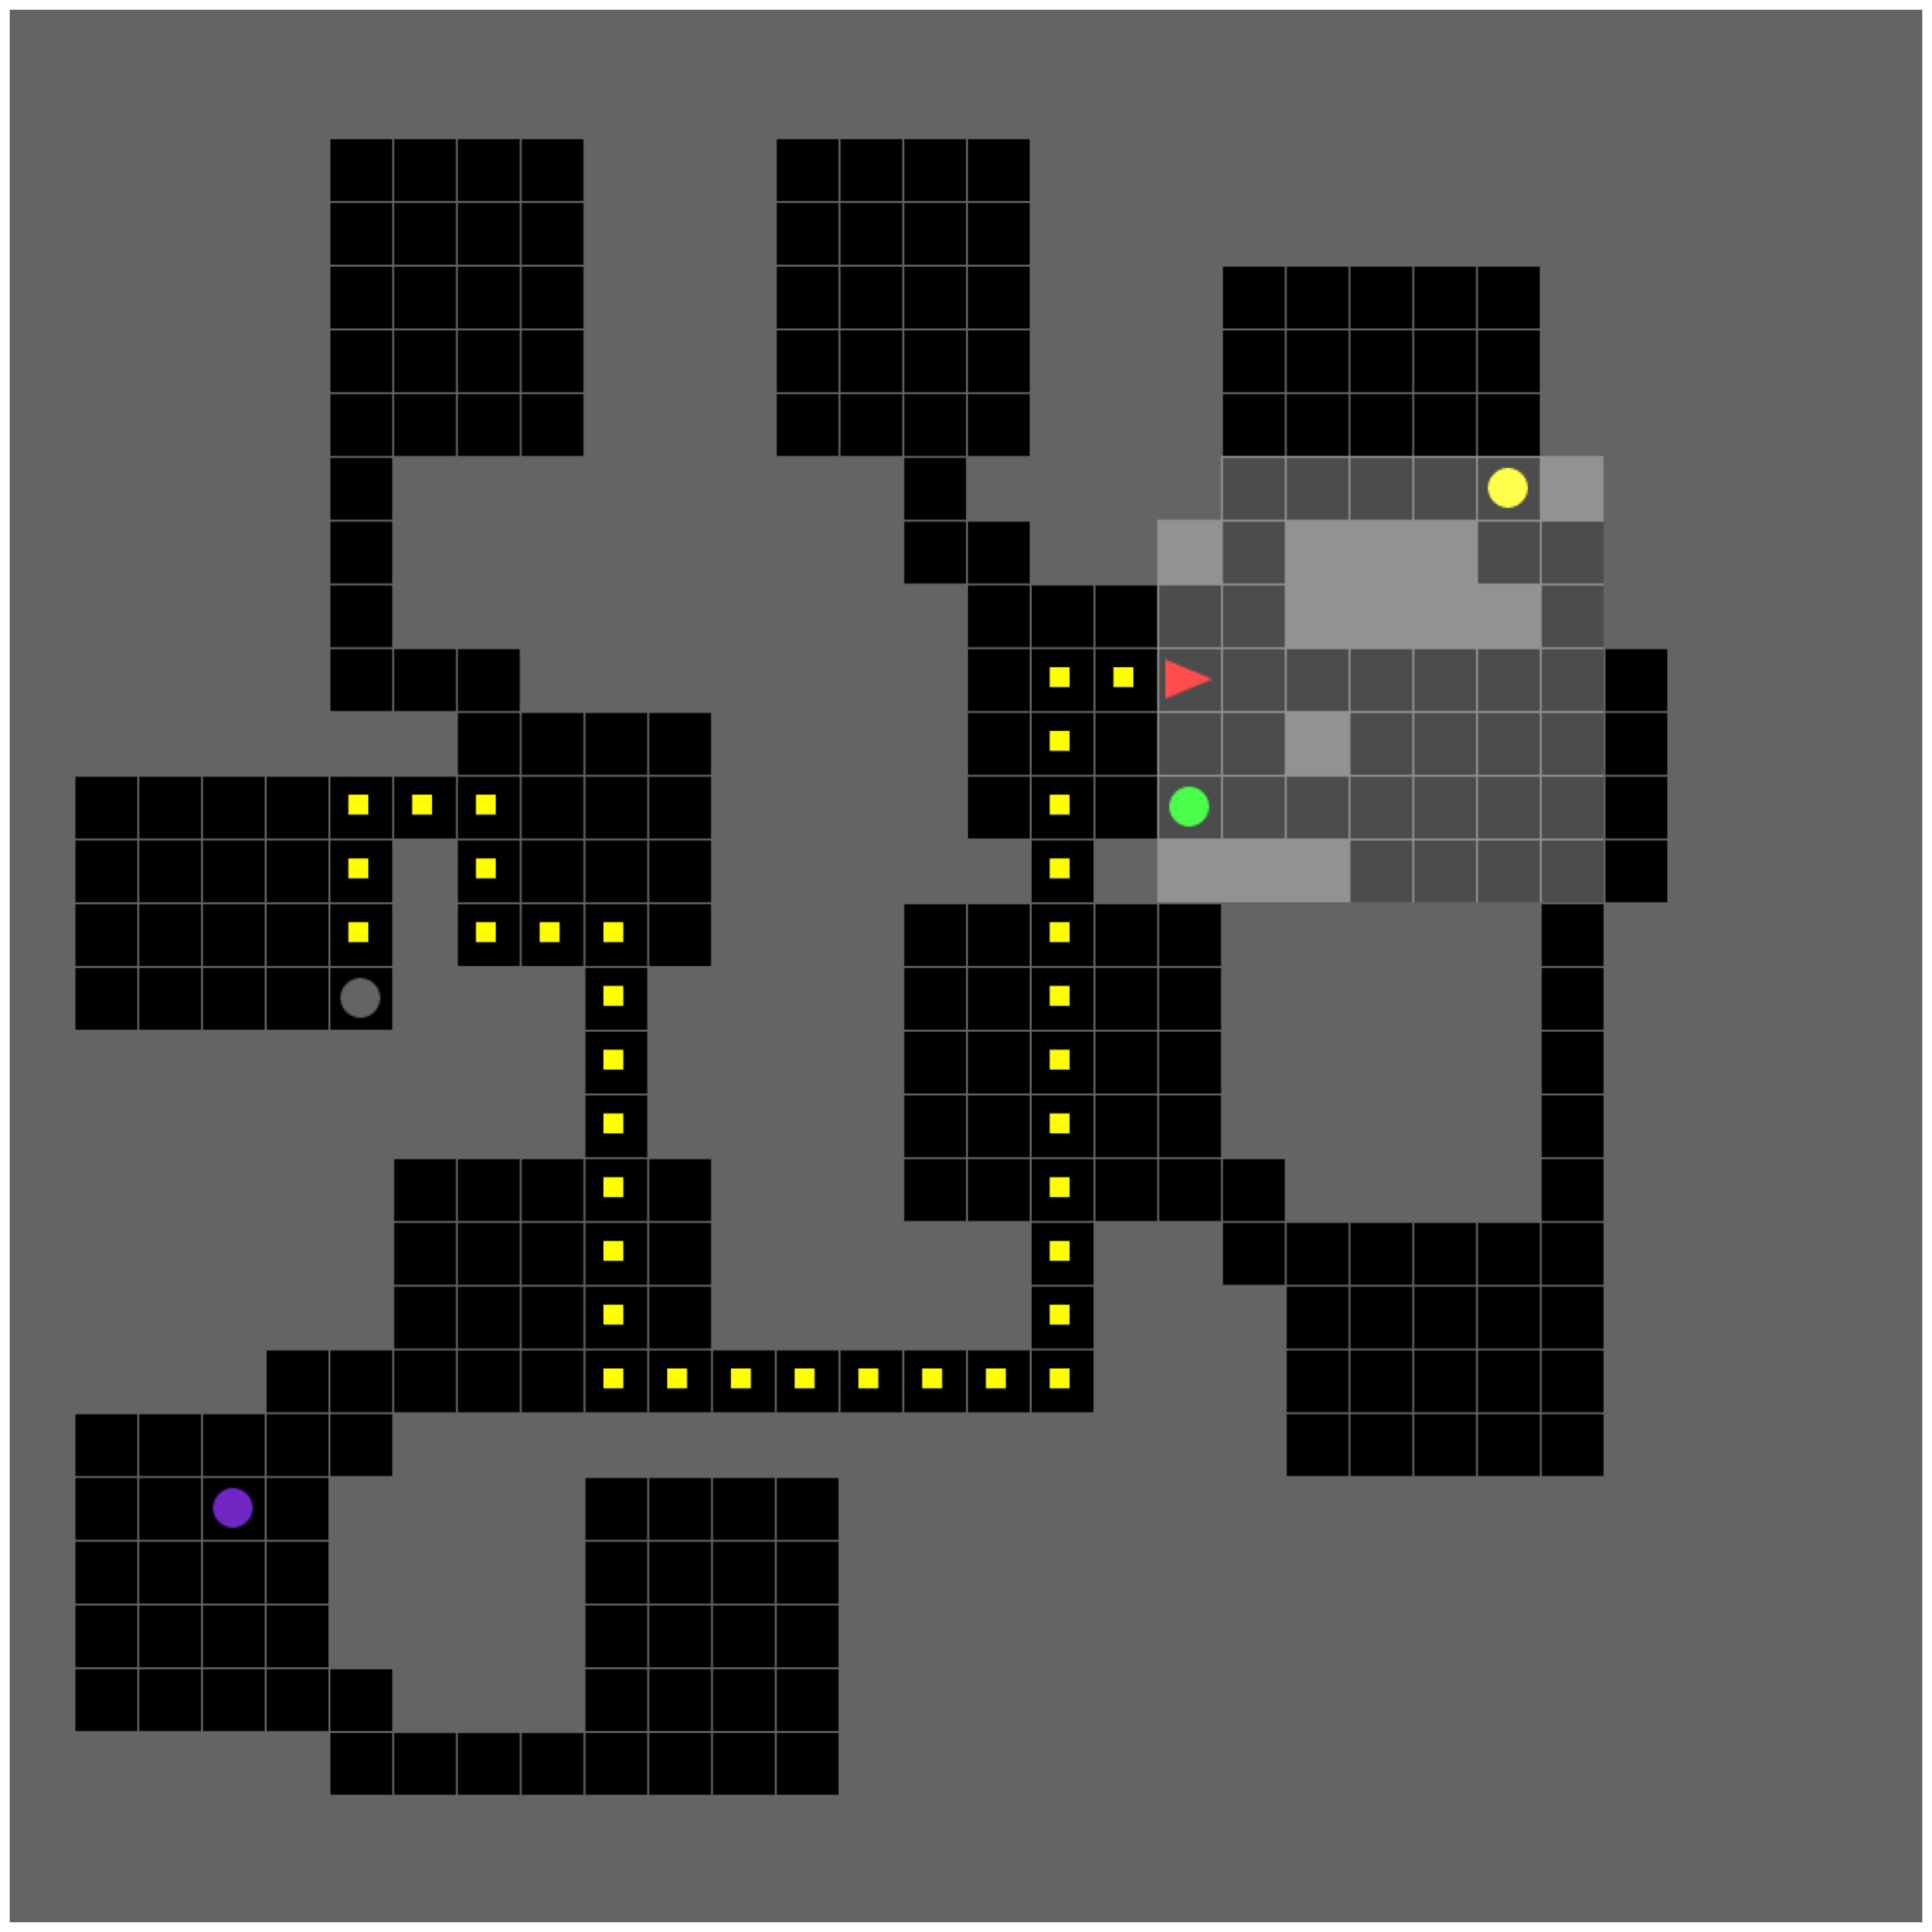

In [6]:
import matplotlib.pyplot as plt
from minigrid.wrappers import RGBImgObsWrapper
from mgmmz import MemoryMazeEnv
import gymnasium as gym

tile_size = 32
env = MemoryMazeEnv(render_mode='rgb_array', grid_size=30, num_goals=4)
#env = gym.make('MemoryMiniGridEnv-v0')
env = RGBImgObsWrapper(env, tile_size=tile_size)
obs, _ = env.reset()
plt.figure(figsize = (20, 20))
plt.imshow(obs['image'])
plt.axis('off')
plt.tight_layout()
plt.show()
print(obs['mission'])
print(env.unwrapped.collected_cues[0].color)
print(f'Agent position: {env.unwrapped.get_agent_pos()}, goal position: {env.unwrapped.get_goal_pos()}')

from mgmmz import shortest_path
shortest_path = shortest_path(env, env.unwrapped.get_agent_pos(), env.unwrapped.get_goal_pos())
#print(shortest_path)
shortest_path = [(pos[1] * tile_size, pos[0] * tile_size) for pos in shortest_path]

ofs_s = (tile_size // 3)
ofs_f = (tile_size // 3) * 2
for pos in shortest_path[1:-1]:
    obs['image'][pos[0] + ofs_s :pos[0] + ofs_f, pos[1] + ofs_s : pos[1] + ofs_f, 0:2] = 255
plt.figure(figsize = (20, 20))
plt.imshow(obs['image'])
plt.axis('off')
plt.tight_layout()
plt.show()

env.unwrapped.store_maze()

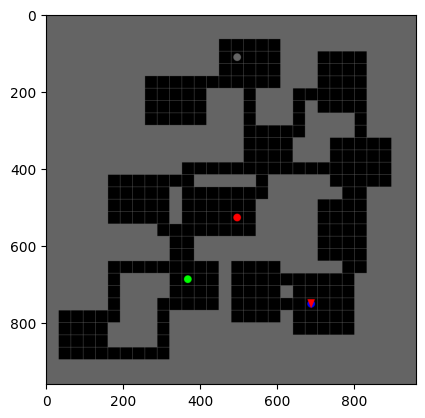

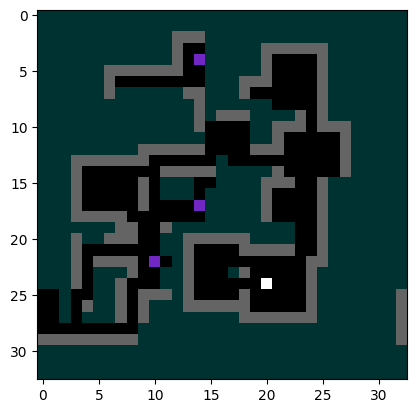

In [3]:
from mgmmz import OptimalSLAMWorldModel
from mgmmz import MemoryMazeEnv
import matplotlib.pyplot as plt
import numpy as np
from minigrid.core.constants import IDX_TO_OBJECT

def act_to_str(action):
    if action == Actions.left: return "left"
    elif action == Actions.right: return "right"
    elif action == Actions.forward: return "forward"
    elif action == Actions.toggle: return "toggle"
    elif action == Actions.pickup: return "pickup"
    elif action == Actions.drop: return "drop"
    elif action == Actions.done: return "done"
    return "error"

def dir_to_str(dir):
    if dir == 0: return "right"
    elif dir == 1: return "down"
    elif dir == 2: return "left"
    elif dir == 3: return "up"
    return "error"

MY_COLORS = {
    "unseen": np.array([0, 50, 50]),
    "empty": np.array([0, 0, 0]),
    "wall": np.array([100, 100, 100]),
    "red": np.array([30, 30, 30]),
    "door": np.array([0, 255, 0]),
    "key": np.array([0, 0, 255]),
    "ball": np.array([112, 39, 195]),
    "box": np.array([255, 255, 0]),
    "goal": np.array([255, 255, 255]),
    "lava": np.array([255, 128, 0]),
    "agent": np.array([255, 0, 255])
}

def transform_to_color(vec: np.ndarray) -> np.ndarray:
    object_name = IDX_TO_OBJECT[vec[0]]
    color = MY_COLORS[object_name]
    return color

def transform_obs_to_image(obs):
    o_flat = obs['image'].reshape(-1, 3)
    color_o = np.apply_along_axis(transform_to_color, 1, o_flat)
    color_o = color_o.reshape(*obs['image'].shape)
    return color_o.transpose((1, 0, 2))

env = MemoryMazeEnv(render_mode='rgb_array', grid_size=30, num_goals=4, max_steps=500000)
wm = OptimalSLAMWorldModel(env)

_, _ = env.reset()
for i in range(500000):
    act = env.action_space.sample()
    obs, rew, term, trunc, info = env.step(act)
    wm.update(obs, act)

    if term or trunc:
        break

    continue

    grid_flat = wm.grid.reshape(-1, 3)
    color_grid = np.apply_along_axis(transform_to_color, 1, grid_flat)
    color_grid = color_grid.reshape(env.height, env.width, 3)

    obs_flat = obs['image'].reshape(-1, 3)
    color_obs = np.apply_along_axis(transform_to_color, 1, obs_flat)
    color_obs = color_obs.reshape(7, 7, 3)
    if obs['direction'] == 0:
        color_obs = np.rot90(color_obs, 2, (1, 0))
    elif obs['direction'] == 1:
        color_obs = np.rot90(color_obs, 1, (1, 0))
    elif obs['direction'] == 2:
        pass
    elif obs['direction'] == 3:
        color_obs = np.rot90(color_obs, 1, (0, 1))
    color_obs = np.flipud(color_obs)

    fig, axes = plt.subplots(1, 2, figsize=(10, 2))
    axes[0].matshow(color_grid)
    axes[1].set_title(dir_to_str(obs['direction']))
    axes[1].matshow(color_obs)
    plt.show()
    sleep(5)


real_color_grid = env.get_full_render(False, 32)
plt.imshow(real_color_grid)
plt.show()

grid_flat = wm.grid.reshape(-1, 3)
color_grid = np.apply_along_axis(transform_to_color, 1, grid_flat)
color_grid = color_grid.reshape(wm.grid.shape[0], wm.grid.shape[1], 3)
plt.imshow(color_grid)
plt.show()


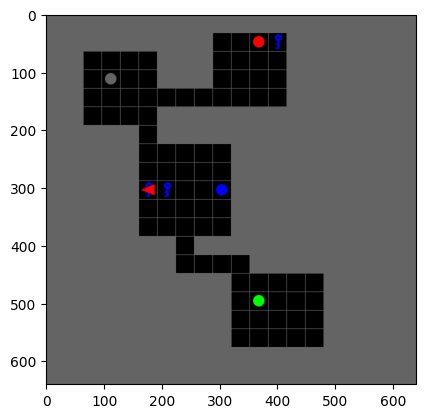

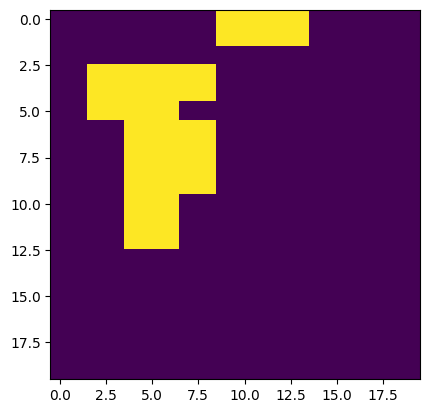

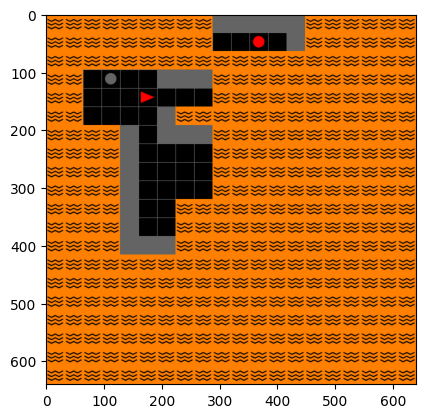

In [4]:
from mgmmz import OptimalWorldModel
from minigrid.core.constants import IDX_TO_OBJECT
from mgmmz import MemoryMazeEnv
import matplotlib.pyplot as plt
import numpy as np
from minigrid.core.world_object import Key

def transf_grid_obs(obs):
    obs_flat = obs.reshape(-1, 3)
    color_obs = np.apply_along_axis(transform_to_color, 1, obs_flat)
    color_obs = color_obs.reshape(obs.shape)
    return color_obs

def act_to_str(action):
    if action == Actions.left: return "left"
    elif action == Actions.right: return "right"
    elif action == Actions.forward: return "forward"
    elif action == Actions.toggle: return "toggle"
    elif action == Actions.pickup: return "pickup"
    elif action == Actions.drop: return "drop"
    elif action == Actions.done: return "done"
    return "error"

def dir_to_str(dir):
    if dir == 0: return "right"
    elif dir == 1: return "down"
    elif dir == 2: return "left"
    elif dir == 3: return "up"
    return "error"

MY_COLORS = {
    "unseen": np.array([0, 255, 0]),
    "empty": np.array([0, 0, 0]),
    "wall": np.array([100, 100, 100]),
    "red": np.array([30, 30, 30]),
    "door": np.array([0, 255, 0]),
    "key": np.array([0, 0, 255]),
    "ball": np.array([112, 39, 195]),
    "box": np.array([255, 255, 0]),
    "goal": np.array([255, 255, 255]),
    "lava": np.array([255, 128, 0]),
    "agent": np.array([255, 0, 255])
}

def transform_to_color(vec: np.ndarray) -> np.ndarray:
    object_name = IDX_TO_OBJECT[vec[0]]
    color = MY_COLORS[object_name]
    return color

def transform_obs_to_image(obs):
    o_flat = o['image'].reshape(-1, 3)
    color_o = np.apply_along_axis(transform_to_color, 1, o_flat)
    color_o = color_o.reshape(*o['image'].shape)
    return color_o.transpose((1, 0, 2))

env = MemoryMazeEnv(render_mode='rgb_array', grid_size=20, num_goals=4, max_steps=500000)
wm = OptimalWorldModel(env)

_, _ = env.reset()
wm.imprint_current_env()
observations = []
positions = []
directions = []
for i in range(10):
    act = env.action_space.sample()
    obs, rew, term, trunc, info = env.step(act)
    agent_position = env.get_agent_pos()
    wm.update(obs, agent_position)
    observations.append(obs['image'])
    positions.append(agent_position)
    directions.append(obs['direction'])

    if i % 20 == 0: env.teleport_agent()
    if term or trunc: break


for pos in positions:
    key = Key('blue')
    key.cur_pos = pos
    key.init_pos = pos
    env.grid.set(pos[0], pos[1], key)

real_color_grid = env.get_full_render(False, 32)
plt.imshow(real_color_grid)
plt.show()

#grid_flat = wm.vis_grid.reshape(-1, 3)
#color_grid = np.apply_along_axis(transform_to_color, 1, grid_flat)
#color_grid = color_grid.reshape(wm.vis_grid.shape[0], wm.vis_grid.shape[1], 3)
##plt.imshow(color_grid.transpose((1, 0, 2)))
#plt.imshow(color_grid)

plt.imshow(wm.vis_grid.transpose((1, 0)))
plt.show()

wm.reset()
real_color_grid = wm.get_maze_shot(False, 32)
plt.imshow(real_color_grid)
plt.show()

#for o, dir in zip(observations, directions):
#    print(dir_to_str(dir))
#    o_flat = o.reshape(-1, 3)
#    color_o = np.apply_along_axis(transform_to_color, 1, o_flat)
#    color_o = color_o.reshape(*o.shape)
#    plt.imshow(color_o.transpose((1, 0, 2)))
#    plt.show()


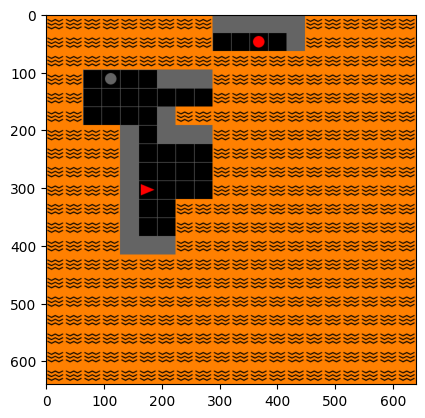

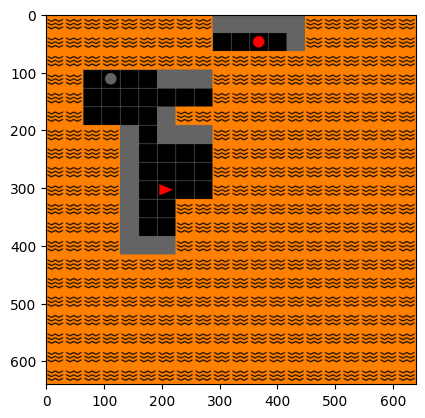

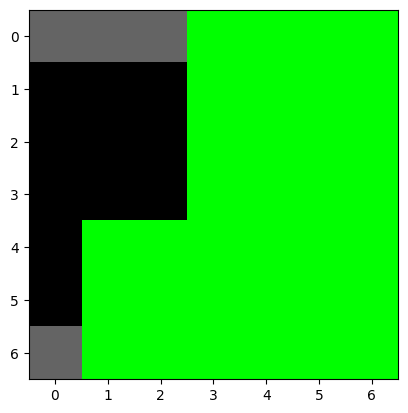

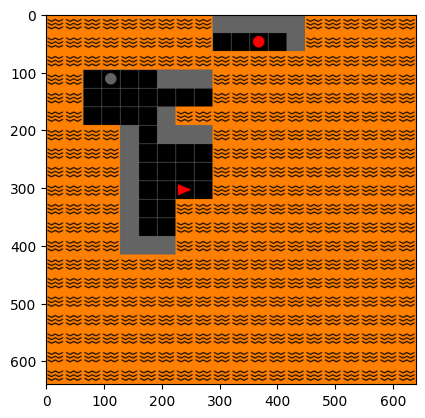

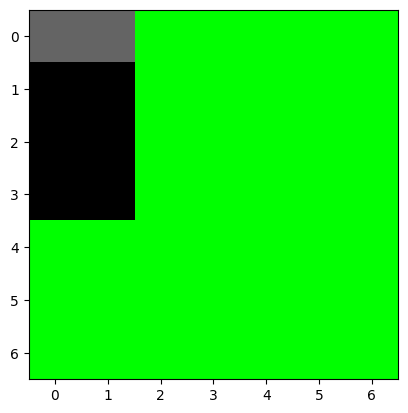

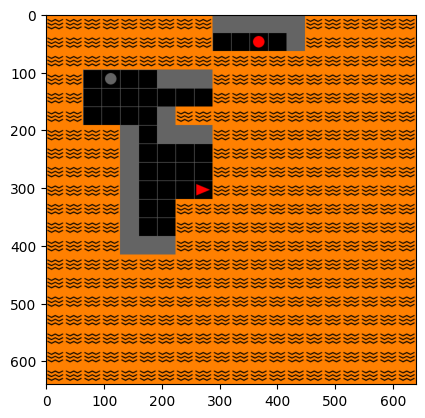

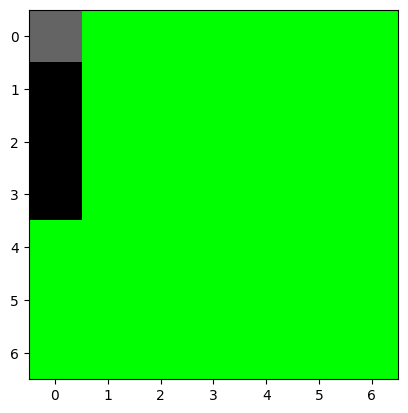

In [5]:

o, _ = wm.reset()
real_color_grid = wm.get_maze_shot(False, 32)
plt.imshow(real_color_grid)
plt.show()

for t in range(3):
    a = wm.action_space.sample()
    o, r, term, trunc, info = wm.step(2)
    real_color_grid = wm.get_maze_shot(False, 32)
    plt.imshow(real_color_grid)
    plt.show()
    plt.imshow(transform_obs_to_image(o))
    plt.show()


In [2]:
# CAUTION: Environment doesn't properly close on MacOS due to pygame bug, re-starting kernel helps
from __future__ import annotations

import pygame
from gymnasium import Env

class ManualControl:
    def __init__(
            self,
            env: Env,
            seed=None,
    ) -> None:
        self.env = env
        self.seed = seed
        self.closed = False

    def start(self):
        """Start the window display with blocking event loop"""
        self.reset(self.seed)

        while not self.closed:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    self.env.close()
                    break
                if event.type == pygame.KEYDOWN:
                    event.key = pygame.key.name(int(event.key))
                    self.key_handler(event)

        pygame.quit()

    def step(self, action: Actions):
        observation, reward, terminated, truncated, _ = self.env.step(action)
        print(f"step={self.env.unwrapped.step_count}, reward={reward:.2f}, cue={observation['cue']}")

        if terminated:
            print("terminated!")
            self.reset(self.seed)
        elif truncated:
            print("truncated!")
            self.reset(self.seed)
        else:
            self.env.render()

    def reset(self, seed=None):
        self.env.reset(seed=seed)
        self.env.render()

    def key_handler(self, event):
        key: str = event.key
        print("pressed", key)

        if key == "escape":
            self.closed = True
            return
        if key == "backspace":
            self.reset()
            return

        key_to_action = {
            "left": Actions.left,
            "right": Actions.right,
            "up": Actions.forward,
            "space": Actions.toggle,
            "pageup": Actions.pickup,
            "pagedown": Actions.drop,
            "tab": Actions.pickup,
            "left shift": Actions.drop,
            "enter": Actions.done,
        }
        if key in key_to_action.keys():
            action = key_to_action[key]
            self.step(action)
        else:
            print(key)

control = ManualControl(wm)
control.start()

error: video system not initialized

In [ ]:
from mgmmz import MemoryMazeEnv, ExpertPolicy
from time import sleep

env = MemoryMazeEnv(render_mode='human', grid_size=30, num_goals=4)

policy = ExpertPolicy(env, 0.2)
obs, info = env.reset()
env.render()
while True:
    act = policy.act(obs)
    obs, r, term, trunc, info = env.step(act)
    env.render()
    print(obs['cue'])
    sleep(0.1)
    if term or trunc:
        break

In [ ]:
from minigrid.core.actions import Actions
actn = [a.value for a in Actions]
print(actn)